<a href="https://colab.research.google.com/github/CoGian/NLP-with-Disaster-Tweets/blob/master/EDA_and_Text_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# import wordcloud
from wordcloud import WordCloud
# import NLTK mainly for stopwords
import nltk
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import  word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import pickle
import operator
import string
!pip install edm
from edm import report
import tensorflow as tf
import re 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
TRAIN_DATASET_PATH = '/content/drive/My Drive/NLP with Disaster Tweets/data/train.csv'
TEST_DATASET_PATH = '/content/drive/My Drive/NLP with Disaster Tweets/data/test.csv'
GLOVE_EMBEDDING_PATH = '/content/drive/My Drive/Glove/glove.840B.300d.pkl'

In [0]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df =  pd.read_csv(TEST_DATASET_PATH)

Define column names

In [0]:
TARGET_COLUMN = 'target'
LOCATION_COLUMN = 'location'
KEYWORD_COLUMN = 'keyword'
METADADATA_COLUMNS = [LOCATION_COLUMN] + [KEYWORD_COLUMN]
TEXT = 'text'

# Exploratory Data Analysis

## Understanding the Data scheme

Print the first 5 tweets

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
num_of_tweets = len(train_df)
print('Train size: {:d}'.format(num_of_tweets))

Train size: 7613


In [8]:
print('Test size: {:d}'.format(len(test_df)))

Test size: 3263


In [9]:
# check for amount of missing(null) values in every column αnd print the precentage of them. 
null_columns=train_df.columns[train_df.isnull().any()]
print((train_df[null_columns].isnull().sum() / num_of_tweets )* 100)

keyword      0.801261
location    33.272035
dtype: float64


Check the frequency of lengths of training tweets

In [10]:
# tokenize
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False)
tokenizer.fit_on_texts(list(train_df[TEXT].astype(str)))
x_train = tokenizer.texts_to_sequences(list(train_df[TEXT].astype(str)))

# count lengths 
training_tweet_lengths = [len(tweet) for tweet in x_train]
print("Max tweet length is %s" % max(training_tweet_lengths))
targets_n_lens = pd.DataFrame(data=train_df[TARGET_COLUMN],columns=[TARGET_COLUMN])
targets_n_lens['lens'] = training_tweet_lengths

Max tweet length is 33


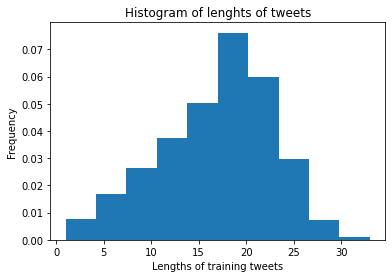

In [11]:
#plot hist 
plt.hist(training_tweet_lengths, density=True, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of lenghts of tweets")
plt.ylabel('Frequency')
plt.xlabel('Lengths of training tweets')
plt.show()

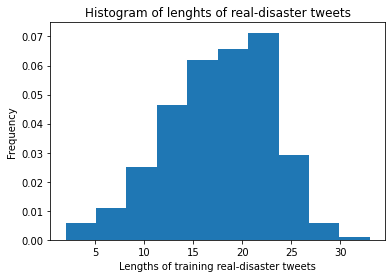

In [12]:
plt.hist(targets_n_lens[targets_n_lens[TARGET_COLUMN] >= .5]['lens'].values, density=True, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of lenghts of real-disaster tweets")
plt.ylabel('Frequency')
plt.xlabel('Lengths of training real-disaster tweets');
plt.show()

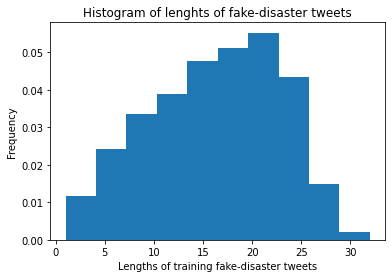

In [13]:
plt.hist(targets_n_lens[targets_n_lens[TARGET_COLUMN] < .5]['lens'].values, density=True, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of lenghts of fake-disaster tweets")
plt.ylabel('Frequency')
plt.xlabel('Lengths of training fake-disaster tweets');
plt.show()

## Understanding the tweets with metadata

In [14]:
num_of_fake_tweets = int(train_df[train_df.target < 0.5][TARGET_COLUMN].count())
num_of_real_tweets = num_of_tweets - num_of_fake_tweets

print('Number of tweets: ',num_of_tweets)
print('Number of fake-disaster tweets: {:d} ,percentage: {:.2f}%'.format(num_of_fake_tweets , (num_of_fake_tweets/num_of_tweets)*100)) 
print('Number of real-disaster tweets: {:d} ,percentage: {:.2f}%'.format(num_of_real_tweets , (num_of_real_tweets/num_of_tweets)*100)) 

Number of tweets:  7613
Number of fake-disaster tweets: 4342 ,percentage: 57.03%
Number of real-disaster tweets: 3271 ,percentage: 42.97%


Let's drop the tweets without metadata and calculate the previous stats

In [15]:
train_df_with_metadata = train_df.loc[:, [TARGET_COLUMN] + METADADATA_COLUMNS ].dropna()
num_of_tweets_with_metadata =  len(train_df_with_metadata)
num_of_real_tweets_with_metadata = int(train_df_with_metadata[train_df_with_metadata.target >= 0.5][TARGET_COLUMN].count())
num_of_fake_tweets_with_metadata = num_of_tweets_with_metadata - num_of_real_tweets_with_metadata

print('Number of tweets with identity: {:d}'.format(num_of_tweets_with_metadata)) 
print('Nummer of fake tweets with metadata: {:d} ,percentage: {:.2f}%'.format(num_of_fake_tweets_with_metadata , (num_of_fake_tweets_with_metadata/num_of_tweets_with_metadata)*100)) 
print('Nummer of real tweets with metdata: {:d} ,percentage: {:.2f}%'.format(num_of_real_tweets_with_metadata , (num_of_real_tweets_with_metadata/num_of_tweets_with_metadata)*100)) 

Number of tweets with identity: 5080
Nummer of fake tweets with metadata: 2884 ,percentage: 56.77%
Nummer of real tweets with metdata: 2196 ,percentage: 43.23%


Let's plot the results 

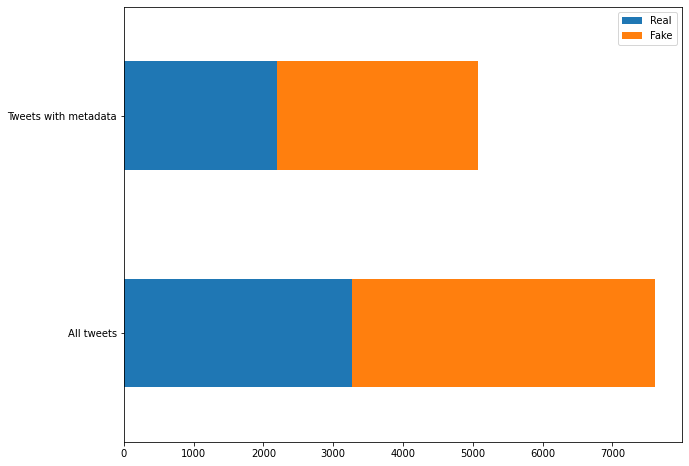

In [16]:
counts_of_samples = pd.DataFrame([['All tweets',num_of_real_tweets,num_of_fake_tweets],
                                  ['Tweets with metadata',num_of_real_tweets_with_metadata,num_of_fake_tweets_with_metadata]],
                                 columns = ['','Real','Fake'])
counts_of_samples.set_index('',inplace=True)
plot1 = counts_of_samples.plot(kind='barh', stacked=True, figsize=(10,8), fontsize=10)
plot1.ticklabel_format(style='plain', axis='x')

Get all keywords

In [17]:
keywords = train_df_with_metadata[KEYWORD_COLUMN].unique()
len(keywords)

221

Find number of real and fake tweets for every keyword

In [18]:
keyword_stats  = [] 
for keyword in keywords:
  tweets = train_df_with_metadata[train_df_with_metadata.keyword == keyword].count().keyword
  real_tweets = train_df_with_metadata[train_df_with_metadata.target == 0][train_df_with_metadata.keyword == keyword].count().keyword
  fake_tweets = tweets - real_tweets
  keyword_stats.append([keyword,tweets,real_tweets,fake_tweets])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Sort by the number of tweets and take the first 20

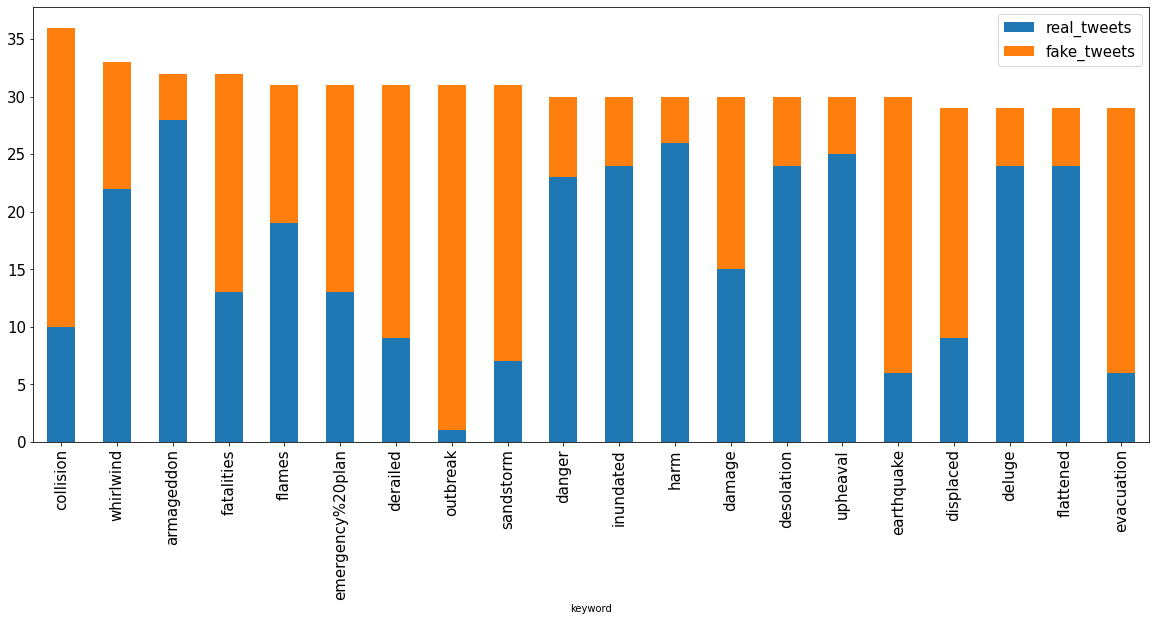

In [19]:
keyword_stats_df = pd.DataFrame(keyword_stats, columns=['keyword','tweets','real_tweets','fake_tweets'])
keyword_stats_df = keyword_stats_df.sort_values(by='tweets', ascending=False).head(20)
keyword_stats_df.set_index(keys= 'keyword', inplace=True)
keyword_stats_df[['real_tweets','fake_tweets']].plot(kind='bar', stacked=True, figsize=(20,8), fontsize=15).legend(prop={'size': 15})

Get all locations 

In [20]:
locations = train_df_with_metadata[LOCATION_COLUMN].unique()
len(locations)

3341

Find number of real and fake tweets for every location

In [21]:
location_stats  = [] 
for location in locations:
  tweets = train_df_with_metadata[train_df_with_metadata.location == location].count().location
  real_tweets = train_df_with_metadata[train_df_with_metadata.target == 0][train_df_with_metadata.location == location].count().location
  fake_tweets = tweets - real_tweets
  location_stats.append([location,tweets,real_tweets,fake_tweets])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Sort by the number of tweets and take the first 20

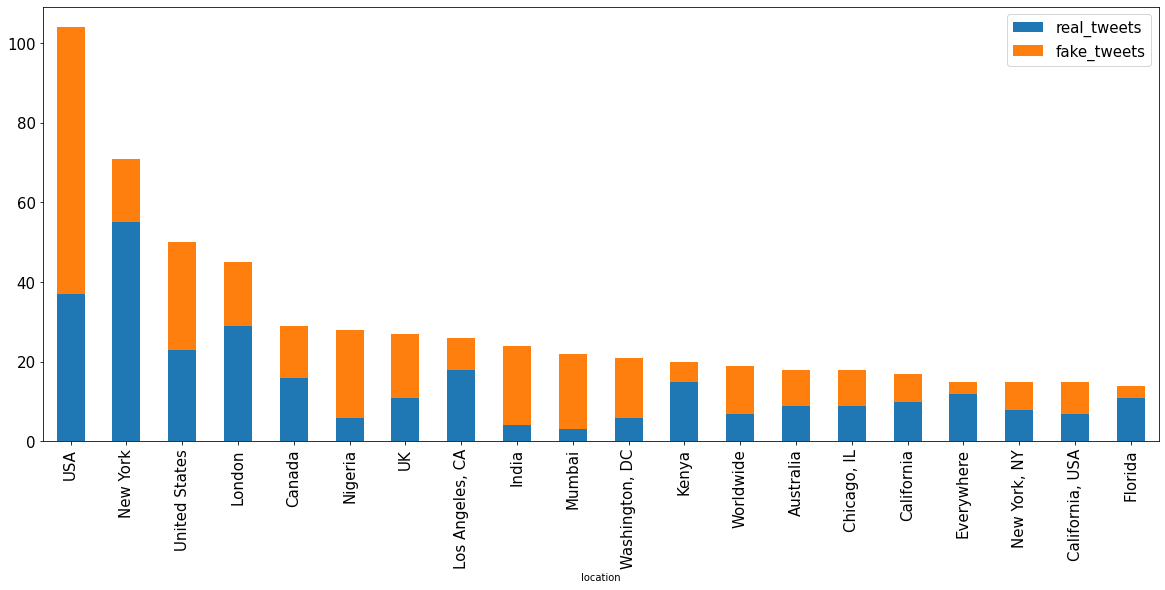

In [22]:
location_stats_df = pd.DataFrame(location_stats, columns=['location','tweets','real_tweets','fake_tweets'])
location_stats_df = location_stats_df.sort_values(by='tweets', ascending=False).head(20)
location_stats_df.set_index(keys= 'location', inplace=True)
location_stats_df[['real_tweets','fake_tweets']].plot(kind='bar', stacked=True, figsize=(20,8), fontsize=15).legend(prop={'size': 15})

## Word Clouds

In [0]:
# we will write a simple function to generate the wordcloud per identity group
def generate_word_cloud(real_tweets, fake_tweets):
    # convert stop words to sets as required by the wordcloud library
    stop_words = set(stopwords.words("english"))
    # create real wordcloud
    wordcloud_real = WordCloud(max_words=1000, background_color="black" ,stopwords=stop_words).generate(real_tweets)
    # create fake wordcloud
    wordcloud_fake = WordCloud(max_words=1000, background_color="black", stopwords=stop_words).generate(fake_tweets)
    # draw the two wordclouds side by side using subplot
    fig = plt.figure(figsize=[20,5])
    fig.add_subplot(1, 2, 1).set_title("Real-Disaster Tweets Wordcloud", fontsize=10)
    plt.imshow(wordcloud_real, interpolation="bilinear")
    plt.axis("off")
    fig.add_subplot(1, 2, 2).set_title("Fake-Disaster Tweets Wordcloud", fontsize=10)
    plt.imshow(wordcloud_fake, interpolation="bilinear")
    plt.axis("off")
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Word Cloud', size = 16)
    plt.show()

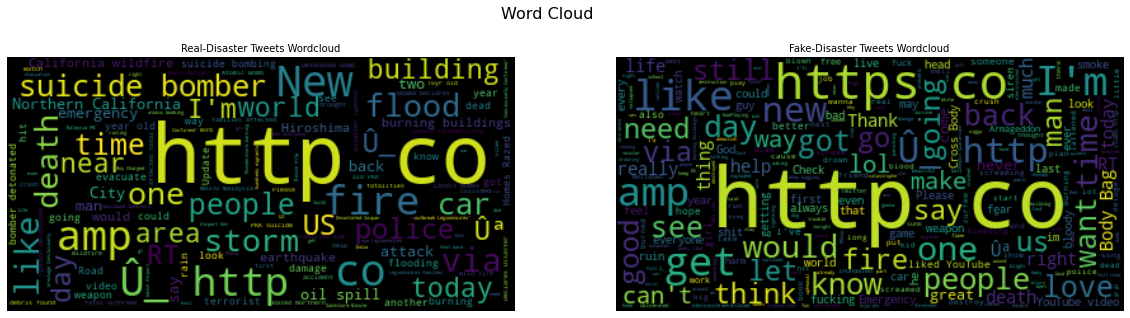

In [24]:
# lets convert the tweets as one long string (as needed by wordcloud)
real_tweets = ' '.join(train_df[train_df.target == 1][TEXT])
fake_tweets = ' '.join(train_df[train_df.target == 0][TEXT])
# draw the wordcloud using the function we created earlier
generate_word_cloud(real_tweets, fake_tweets)

# Preprocessing 

## Word Embeddings

In [0]:
def load_embeddings(path):
    with open(path,'rb') as f:
        embedding_index = pickle.load(f)
    return embedding_index

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

def build_vocab(sentences, verbose =  True):
    """
    build_vocab builds a ordered dictionary of words and their frequency in your text corpus.
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab,embeddings_index):
  """
  goes through a given vocabulary and tries to find word vectors in your embedding matrix
  """
  known_words = {}
  unknown_words = {}
  num_known_words = 0
  num_unknown_words = 0
  for word in vocab.keys():
    try:
      known_words[word] = embeddings_index[word]
      num_known_words += vocab[word]
    except:
      unknown_words[word] = vocab[word]
      num_unknown_words += vocab[word]
      pass
    
  print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
  print('Found embeddings for  {:.2%} of all text'.format(num_known_words / (num_known_words + num_unknown_words)))
  unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

  return unknown_words

In [26]:
import time 
tic = time.time()
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_PATH)
print(f'loaded {len(glove_embeddings)} word vectors in {time.time()-tic}s')

loaded 2196008 word vectors in 29.901554584503174s


In [27]:
vocab = build_vocab(list(train_df[TEXT].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 52.06% of vocab
Found embeddings for  82.68% of all text


[('\x89Û_', 50),
 ('MH370:', 39),
 ('\x89ÛÒ', 38),
 ('Latest:', 31),
 ("Legionnaires'", 31),
 ('#prebreak', 30),
 ("he's", 28),
 ('re\x89Û_', 27),
 ('w/', 26),
 ("there's", 26)]

## Remove urls

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
train_df[TEXT] = train_df[TEXT].apply(lambda x:remove_URL(x))
test_df[TEXT] = test_df[TEXT].apply(lambda x:remove_URL(x))

In [30]:
vocab = build_vocab(list(train_df[TEXT].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 60.81% of vocab
Found embeddings for  86.26% of all text


[('\x89Û_', 50),
 ('MH370:', 39),
 ('\x89ÛÒ', 38),
 ('Latest:', 31),
 ("Legionnaires'", 31),
 ('#prebreak', 30),
 ("he's", 28),
 ('re\x89Û_', 27),
 ('w/', 26),
 ("there's", 26)]

## Delete symbols that we have no embeddings and split contractions 

In [31]:
latin_similar = "’'‘ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿʼNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭīĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ"
white_list = string.ascii_letters + string.digits + latin_similar + ' ' + "'"
print(white_list)
# glove symbols
glove_chars = ''.join([c for c in glove_embeddings if len(c) == 1])
glove_symbols = ''.join([c for c in glove_chars if not c in white_list])
# symbols in tweets 
tweets_chars = build_vocab(list(train_df[TEXT]))
tweets_symbols = ''.join([c for c in tweets_chars if not c in white_list])

symbols_to_delete = ''.join([c for c in tweets_symbols if not c in glove_symbols])
symbols_to_isolate = ''.join([c for c in tweets_symbols if c in glove_symbols]) # we are keeping them 


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789’'‘ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿʼNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭīĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ '


In [0]:
isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}

def handle_symbols(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x

In [0]:
train_df[TEXT] = train_df[TEXT].apply(lambda x:handle_symbols(x))
test_df[TEXT] = test_df[TEXT].apply(lambda x:handle_symbols(x))

Check Coverage

In [34]:
vocab = build_vocab(list(train_df[TEXT].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 77.19% of vocab
Found embeddings for  94.81% of all text


[('MH370', 70),
 ('ÛÒ', 39),
 ("Legionnaires'", 32),
 ('prebreak', 30),
 ("he's", 29),
 ('reÛ', 27),
 ("there's", 26),
 ('ÛÓ', 26),
 ("'The", 25),
 ("Confirmed'", 23)]

Split standard contraction that will fix the issue with the ' punctuation

In [0]:
tokenizer = TreebankWordTokenizer()
def handle_contractions(x):
  x = tokenizer.tokenize(x)
  x = ' '.join(x)
  return x

In [0]:
train_df[TEXT] = train_df[TEXT].apply(lambda x:handle_contractions(x))
test_df[TEXT] = test_df[TEXT].apply(lambda x:handle_contractions(x))

Check Coverage

In [37]:
vocab = build_vocab(list(train_df[TEXT].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 79.44% of vocab
Found embeddings for  95.81% of all text


[('MH370', 71),
 ('ÛÒ', 39),
 ('prebreak', 30),
 ('reÛ', 27),
 ("'The", 26),
 ("'I", 26),
 ('ÛÓ', 26),
 ("'Conclusively", 23),
 ("'We", 22),
 ('Soudelor', 22)]

Need to fix the punctuation ' in the start

In [0]:
def del_punctuation_from_start(x,punc):
  x = [word[1:] if word.startswith(punc) else word for word in x.split()]
  x = ' '.join(x)
  return x

In [0]:
train_df[TEXT] = train_df[TEXT].apply(lambda x:del_punctuation_from_start(x,"'"))
test_df[TEXT] = test_df[TEXT].apply(lambda x:del_punctuation_from_start(x,"'"))

In [40]:
vocab = build_vocab(list(train_df[TEXT].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 80.82% of vocab
Found embeddings for  96.20% of all text


[('MH370', 71),
 ('ÛÒ', 39),
 ('prebreak', 30),
 ('reÛ', 27),
 ('ÛÓ', 26),
 ('Soudelor', 22),
 ('bestnaijamade', 18),
 ('ÛÏ', 18),
 ('Funtenna', 17),
 ('UTC2015', 14)]

## Check if lowercase/uppercase a word without embedding , find embedding  

In [0]:
def check_case(comment,embeddings_index):
  comment = comment.split()
  
  comment = [word if word in embeddings_index else word.lower() if word.lower() in embeddings_index else word.title() if word.title() in embeddings_index else word
             for word in comment ]

  comment = ' '.join(comment)
  return comment 

In [0]:
train_df[TEXT]=train_df[TEXT].apply(lambda x: check_case(x,glove_embeddings))
test_df[TEXT]=test_df[TEXT].apply(lambda x: check_case(x,glove_embeddings))

In [43]:
vocab = build_vocab(list(train_df[TEXT].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 81.69% of vocab
Found embeddings for  96.37% of all text


[('MH370', 71),
 ('ÛÒ', 39),
 ('prebreak', 30),
 ('reÛ', 27),
 ('ÛÓ', 26),
 ('Soudelor', 22),
 ('bestnaijamade', 18),
 ('ÛÏ', 18),
 ('Funtenna', 17),
 ('UTC2015', 14)]

## More cleaning of the contractions

In [0]:
contraction_mapping = {
    "daesh" : "isis", "Qur'an" : "quran",
    "Trump's" : 'trump is',"'cause": 'because',',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have',
    'can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I',
    'ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat',\
    'TrumpCare':'Trump care','Trumpcare':'Trump care', 'OBAMAcare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer',\
    'ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','Sᴛᴀʀᴛ':'start','gubmit':'submit','CO₂':'carbon dioxide','ғɪʀsᴛ':'first',\
    'ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra',\
    'Gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',\
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','Mᴀᴋᴇ':'make',\
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'Maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'Sᴛaʀᴛ':' start', 'SHOPO':'shop',
    }

In [0]:
def clean_contr(x, dic):
    x = x.split()
    x = [dic[word] if word in dic else dic[word.lower()] if word.lower() in dic else word for word in x ]
    x = ' '.join(x)
    return x 

In [0]:
train_df[TEXT]=train_df[TEXT].apply(lambda x: clean_contr(x,contraction_mapping))
test_df[TEXT]=test_df[TEXT].apply(lambda x: clean_contr(x,contraction_mapping))

In [47]:
vocab = build_vocab(list(train_df[TEXT].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 81.71% of vocab
Found embeddings for  96.38% of all text


[('MH370', 71),
 ('ÛÒ', 39),
 ('prebreak', 30),
 ('reÛ', 27),
 ('ÛÓ', 26),
 ('Soudelor', 22),
 ('bestnaijamade', 18),
 ('ÛÏ', 18),
 ('Funtenna', 17),
 ('UTC2015', 14)]

# Save cleared datasets

In [0]:
train_df.to_csv(r'/content/drive/My Drive/NLP with Disaster Tweets/data/train_cleared.csv', index = False)
test_df.to_csv(r'/content/drive/My Drive/NLP with Disaster Tweets/data/test_cleared.csv', index = False)